# 11 空間構造のある階層ベイズモデル

In [1]:
using Distributed
addprocs(3)
@everywhere begin
    using Pkg
    Pkg.activate(".")
    Pkg.instantiate()
end

      From worker 2:	 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


      From worker 4:	 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`
      From worker 3:	 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


In [2]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using LinearAlgebra
@everywhere using Mamba
using Plots
@everywhere using Random
using SparseArrays
using Statistics
using StatsBase
@everywhere Random.seed!(0)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/matsueushi/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 11.1 例題 : 一次元空間上の個体数分布
### 例題の一次元空間上の架空データ

In [3]:
df = CSV.read(joinpath("..", "data/section11.csv"))
disallowmissing!(df)

50×2 DataFrame
│ Row │ y     │ m       │
│     │ Int64 │ Float64 │
├─────┼───────┼─────────┤
│ 1   │ 0     │ 2.15498 │
│ 2   │ 3     │ 3.25417 │
│ 3   │ 2     │ 4.62867 │
│ 4   │ 5     │ 6.23412 │
│ 5   │ 6     │ 7.99073 │
│ 6   │ 16    │ 9.79447 │
│ 7   │ 8     │ 11.5334 │
│ 8   │ 14    │ 13.1043 │
│ 9   │ 11    │ 14.4263 │
│ 10  │ 10    │ 15.4488 │
⋮
│ 40  │ 17    │ 11.6433 │
│ 41  │ 8     │ 11.2182 │
│ 42  │ 7     │ 10.6165 │
│ 43  │ 10    │ 9.83561 │
│ 44  │ 4     │ 8.88885 │
│ 45  │ 5     │ 7.80682 │
│ 46  │ 5     │ 6.63673 │
│ 47  │ 7     │ 5.43822 │
│ 48  │ 4     │ 4.27619 │
│ 49  │ 3     │ 3.21171 │
│ 50  │ 1     │ 2.29286 │

横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

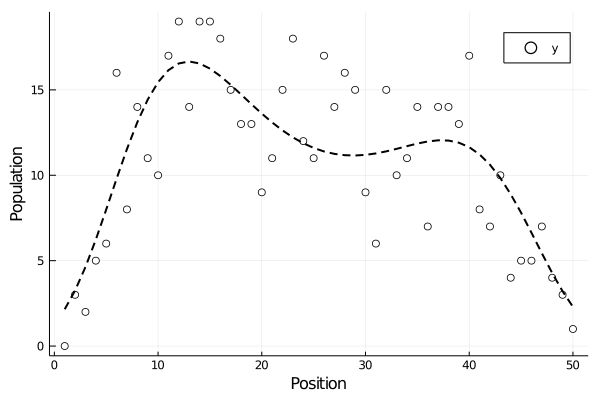

In [4]:
scatter(1:50, df.y, xlabel="Position", ylabel="Population", markercolor=:white, label="y")
plot!(1:50, df.m, linewidth=2, linecolor=:black, linestyle=:dash, label="")

## 11.2 階層ベイズモデルに空間構造を組み込む
まず, 個体数$y_i$は, すべでの区画で共通する平均$\lambda$のポアソン分布に従うとしてみる.
$$\begin{align} y_i \sim \text{Poisson}(\lambda),\ p(y_j \mid \lambda) = \frac{\lambda^{y_i}\exp(-\lambda)}{y_j!} \end{align}$$
このように仮定してすると, 平均$\lambda$と標本平均と等しいとしてみる.
### 標本平均

In [5]:
mean(df.y)

10.88

ところが標本分散を求めてみると,

In [6]:
var(df.y)

27.373061224489796

となり, 標本平均の3倍近くなっている. そのため個体数が全ての区画で共通する平均$\lambda$のPoisson分布に従うと言う仮定は成立していなさそう.

そのため, 区間$j$ごとに平均$\lambda_i$が異なっているとし, 平均個体数を切片$\beta$と場所差$r_j$を用いて
$$\begin{align} \log \lambda_i = \beta + r_j \end{align}$$
と表す.

### 11.2.1. 空間構造のない階層事前分布
場所差$r_j$の事前分布を第10章で使ったような階層事前分布
$$\begin{align} r_j \sim \text{Normal}(0, s^2),\ p(r_j \mid s) = \frac{1}{\sqrt{2\pi s^2}}\exp \left( -\frac{r_j^2}{2s^2} \right) \end{align}$$
であるとしてモデリングしてみる.

In [7]:
model1 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Mamba.Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),

    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),

    beta = Stochastic(() -> Normal(0, 100)),

    r = Stochastic(1, s -> Normal(0, s), false),

    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [8]:
data1 = let y=df.y[:]
    Dict{Symbol, Any}(
        :y => y,
        :N => length(y),
    )
end

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]

In [9]:
inits1 = [
    Dict{Symbol, Any}(
        :y => data1[:y],
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(data1[:y])),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta => 0.0,:y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s => 1.0,:r => [0.06791074260357777, 0.0828413482900036, -0.03530074003005963, -0.013485387193052173, 0.05866170746331098, 0.029733585084941616, 0.006494754854834233, -0.010901738508171745, -0.051421039083332204, 0.15743302021369893  …  0.04815560395242518, -0.032194315289596945, 0.024634263300826426, -0.01787887323130224, -0.1477880724921868, -0.018542418173298963, 0.12697236910352527, -0.01625038643324805, -0.0067186705281941685, 0.0577281986591789])
 Dict(:beta => 0.0,:y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s => 1.0,:r => [0.08913150910765416, -0.22944903432735064, -0.11730257522688414, -0.08799154991652847, -0.049404265980430656, 0.05119593023121582, -0.07587009830949236, -0.0767959839503059, -0.0030303176320568017, -0.13192351950482664  …  0.044157293235560335, 0.1676893702842105, 0.02384811702037166, 0.231379252131

In [10]:
scheme1 = [
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:r]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
[:s]

CodeInfo(
1 ─ %1 = π (Mamba.var"#288#290"{Bool,Float64}(false, 1.0), Core.Compiler.Const(Mamba.var"#288#290"{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
[:beta]

Code

In [11]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data1, inits1, 60000, burnin=10000, thin=10, chains=3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 4:	Chain 3:   0% [15:57:53 of 15:58:03 remaining]
      From worker 2:	Chain 1:   0% [16:21:33 of 16:21:43 remaining]
      From worker 3:	Chain 2:   0% [16:39:58 of 16:40:08 remaining]
      From worker 4:	Chain 3:  10% [0:04:21 of 0:04:50 remaining]
      From worker 2:	Chain 1:  10% [0:04:25 of 0:04:54 remaining]
      From worker 3:	Chain 2:  10% [0:04:29 of 0:04:58 remaining]
      From worker 4:	Chain 3:  20% [0:03:25 of 0:04:17 remaining]
      From worker 2:	Chain 1:  20% [0:03:29 of 0:04:22 remaining]
      From worker 3:	Chain 2:  20% [0:03:34 of 0:04:27 remaining]
      From worker 4:	Chain 3:  30% [0:03:00 of 0:04:17 remaining]
      From worker 2:	Chain 1:  30% [0:03:02 of 0:04:20 remaining]
      From worker 3:	Chain 2:  30% [0:03:05 of 0:04:24 remaining]
      From worker 4:	Chain 3:  40% [0:02:25 of 0:04:01 remaining]
      From worker 2:	Chain 1:  40% [0:02:28 of 0:04:07 remaining]
      From worker 3

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.44292983480499487 2.2342145625519696 … 4.952750970984432 2.8688707562757085; 0.6358954039270779 2.1391936256352566 … 5.8989232779769925 3.8377652264013364; … ; 0.5564147746822802 2.3142622493211564 … 6.677076440090735 2.1936676622666504; 0.4151445576380581 2.2750917013149903 … 3.3838116217022014 6.659373730633778]

[0.3280539989283596 2.314864761855768 … 5.823101452980162 4.603684920702728; 0.4548226065804652 2.266043256255194 … 5.794189847599338 6.616543371835387; … ; 0.3799524743117429 2.4882075334261122 … 8.107677685342841 4.172803811000025; 0.4357266683540653 2.3595414358956077 … 6.955971770106368 4.8859667249903245]

[0.38021226209535675 2.288647721577358 … 4.220990811275271 5.063744395339045; 0.42494684680000816 2.3559429344688176 … 5.015637471086946 5.710228431203957; … ; 0.44563630619064276 2.318625347205648 … 7.4003848455191035 5.166918911036204; 0.45604124

In [12]:
describe(sim1)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD       Naive SE       MCSE      ESS
         s  0.45288281 0.083457683 0.0006814291 0.0008810132 5000
      beta  2.29593063 0.081474328 0.0006652351 0.0009725545 5000
 lambda[1]  4.44038776 1.634068468 0.0133421132 0.0150941201 5000
 lambda[2]  5.90357452 1.878552457 0.0153383166 0.0171619680 5000
 lambda[3]  5.41733054 1.811264420 0.0147889121 0.0149692684 5000
 lambda[4]  6.99471927 2.084819703 0.0170224816 0.0184045216 5000
 lambda[5]  7.58694074 2.176108944 0.0177678551 0.0188381675 5000
 lambda[6] 14.25232419 3.287937420 0.0268458966 0.0295881622 5000
 lambda[7]  8.82004638 2.391507581 0.0195265776 0.0192719856 5000
 lambda[8] 12.84564208 3.061464125 0.0249967499 0.0273492848 5000
 lambda[9] 10.80007798 2.754973714 0.0224942662 0.0232671949 5000
lambda[10] 10.07424856 2.593069011 0.0211723198 0.0201991247 5000
lambda[11] 15.01808636

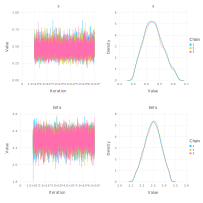

In [13]:
p1 = Mamba.plot(sim1, legend=true)
Mamba.draw(p1[:, 1:2], nrow=2, ncol=2)

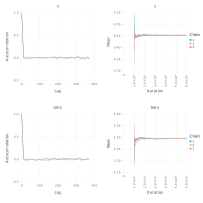

In [14]:
p2 = Mamba.plot(sim1, [:autocor, :mean], legend=true)
Mamba.draw(p2[:, 1:2], nrow=2, ncol=2)

$\lambda$の中央値、95%信頼区間をプロットしてみる

In [15]:
mre = quantile(sim1).value[3:end, :]

50×5 Array{Float64,2}:
  1.7897    3.269     4.24852   5.43145   8.09843
  2.79934   4.57507   5.6866    7.04835  10.1326
  2.47304   4.1121    5.22825   6.50653   9.48405
  3.58224   5.48064   6.77393   8.24179  11.7233
  3.95667   6.0368    7.36821   8.88612  12.489
  8.68023  11.9165   13.9475   16.2729   21.5459
  4.76353   7.10793   8.60287  10.2846   14.1373
  7.74239  10.6851   12.5443   14.6865   19.5773
  6.21808   8.82722  10.5327   12.4466   16.919
  5.765     8.23471   9.8095   11.6067   15.9466
  9.27565  12.6212   14.7115   17.076    22.4416
 10.3301   13.8998   16.1433   18.722    24.4687
  7.67074  10.6963   12.6221   14.7611   19.7063
  ⋮                                      
  7.18509  10.0463   11.8628   13.8902   18.6075
  9.16272  12.5369   14.6808   17.0593   22.5038
  4.86787   7.10891   8.60886  10.2902   14.2381
  4.35225   6.54993   7.98105   9.59224  13.2211
  5.76606   8.2434    9.8363   11.6628   15.7043
  3.16345   5.02119   6.23971   7.63621  10.8304
  3.

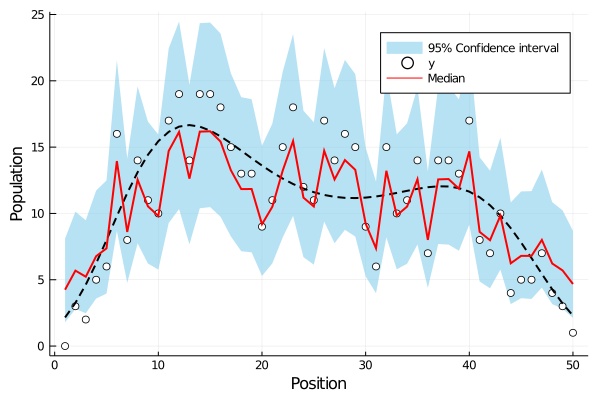

In [16]:
Plots.plot(1:50, mre[:, 1], lw=0,
    fillrange=mre[:, 5],
    fillcolor=:skyblue,
    fillalpha=0.6,
    label="95% Confidence interval")
scatter!(1:50, df.y, xlabel="Position", ylabel="Population", markercolor=:white, label="y")
plot!(1:50, df.m, linewidth=2, linecolor=:black, linestyle=:dash, label="")
plot!(1:50, mre[:, 3], linewidth=2, linecolor=:red, label="Median")

11.2.2 空間構造のある階層事前分布
ある区間はそれと隣接する区間とだけ相互作用すると仮定する.
近傍数は$n_j = 2 \ (j \neq 1, 50), 1 \ (j = 1, 50)$となる.
$$\begin{align} \mu_j = \frac{r_{j-1} + r_{j+1}}{2}\ (j \neq 1, 50), \mu_1 = r_2, \mu_{50} = r_{49},\\
r_j \mid \mu_j, s \sim \text{Normal}\left(\mu_j, \frac{s}{\sqrt{n_j}}\right) \end{align}$$
と言うモデルを考える.
### 11.3 空間統計モデルをデータに当てはめる
CARモデルを実装する。 参考 : https://github.com/matsueushi/lip_stick_mamba

In [17]:
model2 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Mamba.Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),

    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),

    beta = Stochastic(() -> Normal(0, 100)),

    r = Stochastic(1,
        (s, alpha, N, D, adj) ->
            MvNormalCanon(zeros(N), 1 / (s * s) * (D - alpha * adj)),
        false
    ),

    alpha = Stochastic(() -> Uniform()),

    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [18]:
adj = zeros(50, 50)
for i in 1:50-1
    adj[i, i+1] = 1
    adj[i+1, i] = 1
end
adj

50×50 Array{Float64,2}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [19]:
D = Diagonal(vec(sum(adj, dims=2)))

50×50 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    

In [20]:
data2 = let y=df.y[:]
    Dict{Symbol, Any}(
        :y => y,
        :N => length(y),
        :adj => adj,
        :D => D,
    )
end

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => [0.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0…
  :y   => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [21]:
inits2 = [
    Dict{Symbol, Any}(
        :y => data2[:y],
        :alpha => 0.9,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), data2[:N]),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha => 0.9,:beta => 0.0,:y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s => 1.0,:r => [-0.09795339466733807, -0.0760265311442331, 0.10226540063769154, -0.08323334131790922, -0.14429277867026527, -0.1313684989960247, 0.01456142708384867, 0.13132625511807755, -0.14378554051189704, -0.06851083574480152  …  -0.15960024025105368, -0.09958703868973626, -0.06088355396146079, -0.17925102435122792, -0.11445563389607334, -0.22839237549461175, -0.21110173410586724, 0.12193347515820448, -0.022210496385416296, -0.10024316257728434])
 Dict(:alpha => 0.9,:beta => 0.0,:y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s => 1.0,:r => [-0.05037603628866358, 0.006467678861102818, 0.09076366976797653, 0.07208393833885718, -0.06865641489363825, -0.023769600340388386, -0.10328856926775093, -0.1800550173390088, -0.11644620059618659, 0.12115810954933637  …  -0.07945657412065438, 0.02762571118969768, -0.07118391

In [22]:
scheme2 = [
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:r]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
[:s]

CodeInfo(
1 ─ %1 = π (Mamba.var"#288#290"{Bool,Float64}(false, 1.0), Core.Compiler.Const(Mamba.var"#288#290"{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
[:alpha, :bet

In [23]:
setsamplers!(model2, scheme2)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [24]:
sim2 = mcmc(model2, data2, inits2, 60000, burnin=10000, thin=10, chains=3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 2:	Chain 2:   0% [0:40:11 of 0:40:11 remaining]
      From worker 3:	Chain 3:   0% [0:43:55 of 0:43:55 remaining]
      From worker 4:	Chain 1:   0% [1:08:46 of 1:08:47 remaining]
      From worker 2:	Chain 2:  10% [0:04:46 of 0:05:17 remaining]
      From worker 4:	Chain 1:  10% [0:05:05 of 0:05:39 remaining]
      From worker 3:	Chain 3:  10% [0:05:25 of 0:06:01 remaining]
      From worker 2:	Chain 2:  20% [0:03:58 of 0:04:57 remaining]
      From worker 4:	Chain 1:  20% [0:04:10 of 0:05:12 remaining]
      From worker 3:	Chain 3:  20% [0:04:26 of 0:05:33 remaining]
      From worker 2:	Chain 2:  30% [0:03:42 of 0:05:18 remaining]
      From worker 4:	Chain 1:  30% [0:03:58 of 0:05:40 remaining]
      From worker 3:	Chain 3:  30% [0:04:05 of 0:05:50 remaining]
      From worker 2:	Chain 2:  40% [0:03:13 of 0:05:21 remaining]
      From worker 4:	Chain 1:  40% [0:03:24 of 0:05:41 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.26334208174236273 0.9731068689725625 … 5.497441116232437 3.8004502440929424; 0.2700038499789437 0.9879830243131235 … 3.9311261292446065 2.766518105635337; … ; 0.43424999933503594 0.9340589470342782 … 4.617658413236691 2.392817577243822; 0.32113926135753956 0.9529846198907292 … 3.875090239482293 3.2367610513281546]

[0.3145927561711193 0.994669857294239 … 3.5716807312236485 3.4866681231962957; 0.3141481258670795 0.9220631582437593 … 2.905513341219474 2.520735490502209; … ; 0.4605999457272746 0.9170569161319315 … 4.28046813052071 1.874294903551127; 0.47323854190401327 0.8533843374185491 … 4.1315856928275085 3.5029609807540765]

[0.3631231033823732 0.9996873514709692 … 3.922387757951779 2.6794483291950604; 0.24890812806148407 0.998888880554853 … 2.2078807121518507 3.163207069593799; … ; 0.2276366716434271 0.9801561898095693 … 2.8425926921791067 2.6398738395881955; 0.24

In [25]:
describe(sim2)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD        Naive SE       MCSE         ESS   
         s  0.29044620 0.071234279 0.00058162545 0.0011644012 3742.59462
     alpha  0.97491233 0.028347664 0.00023145771 0.0006050712 2194.93464
      beta  2.24892577 0.326730267 0.00266774146 0.0221615517  217.35939
 lambda[1]  2.80528592 1.073977478 0.00876898939 0.0145292615 5000.00000
 lambda[2]  3.37296968 1.065076891 0.00869631640 0.0150172811 5000.00000
 lambda[3]  3.99357657 1.119815964 0.00914325906 0.0152512388 5000.00000
 lambda[4]  5.37670547 1.342317063 0.01095997292 0.0158853999 5000.00000
 lambda[5]  7.20117313 1.604773639 0.01310292189 0.0188499677 5000.00000
 lambda[6] 10.73884786 2.326122355 0.01899270950 0.0263667134 5000.00000
 lambda[7] 10.19028854 2.027520219 0.01655463326 0.0205221734 5000.00000
 lambda[8] 11.85668970 2.302411375 0.01879911015 0.0221185082 5000.00000
 lam

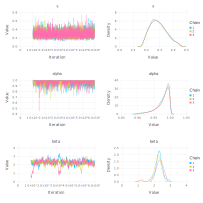

In [26]:
p3 = Mamba.plot(sim2, legend=true)
Mamba.draw(p3[:, 1:3], nrow=3, ncol=2)

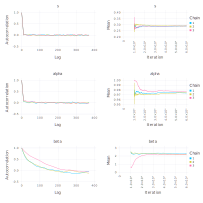

In [27]:
p4 = Mamba.plot(sim2, [:autocor, :mean], legend=true)
Mamba.draw(p4[:, 1:3], nrow=3, ncol=2)

In [28]:
mre2 = quantile(sim2).value[4:end, :]

50×5 Array{Float64,2}:
  1.11416   2.01867   2.66743   3.44392   5.30043
  1.627     2.6062    3.26874   4.02118   5.77273
  2.10837   3.18953   3.89197   4.6695    6.47347
  3.13893   4.42756   5.26264   6.20241   8.34228
  4.43297   6.07563   7.063     8.18084  10.7813
  6.97874   9.08412  10.4773   12.107    16.0258
  6.67557   8.78675  10.0101   11.4083   14.6519
  7.96528  10.2421   11.6491   13.2107   16.9983
  7.76977  10.0559   11.4621   13.0191   16.4335
  8.06171  10.5005   11.9743   13.5664   17.1541
 10.475    13.271    15.0332   16.9806   21.32
 11.6692   14.6916   16.5349   18.6679   23.2443
 10.7967   13.8387   15.5562   17.4722   21.7142
  ⋮                                      
  8.77541  11.2753   12.7866   14.4608   18.3469
  8.80204  11.3043   12.9125   14.7037   18.902
  6.31723   8.33508   9.59178  10.9599   14.0411
  5.28876   7.0862    8.19497   9.41153  12.224
  4.99757   6.7037    7.75653   8.94782  11.9405
  3.73564   5.16613   6.09027   7.08273   9.40386
  3

### Plot

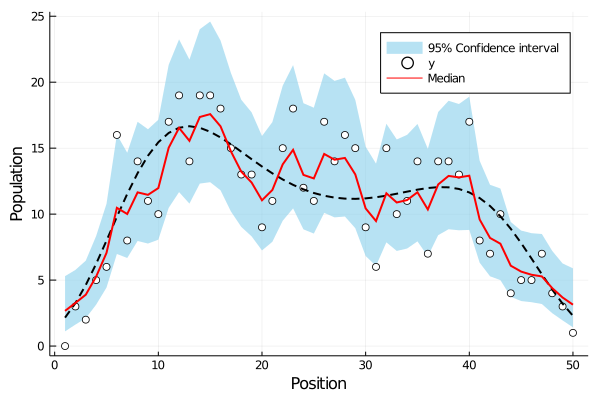

In [29]:
Plots.plot(1:50, mre2[:, 1], lw=0,
    fillrange=mre2[:, 5],
    fillcolor=:skyblue,
    fillalpha=0.6,
    label="95% Confidence interval")
scatter!(1:50, df.y, xlabel="Position", ylabel="Population",
        markercolor=:white, label="y")
plot!(1:50, df.m, linewidth=2, linecolor=:black, linestyle=:dash, label="")
plot!(1:50, mre2[:, 3], linewidth=2, linecolor=:red, label= "Median")

## 11.5 空間相関モデルと欠測のある観測データ
Missing Values Sampler

https://mambajl.readthedocs.io/en/latest/samplers/miss.html

を使って、欠測のある観測データを使った予測を行う。
### まずは、空間相関のないモデル

In [30]:
y_missing = convert(Vector{Union{Missing, Float64}}, df.y)
missing_place = [6, 9, 12, 13, 26, 27, 28, 29, 30]
y_missing[missing_place] .= NaN
y_missing

50-element Array{Union{Missing, Float64},1}:
   0.0
   3.0
   2.0
   5.0
   6.0
 NaN
   8.0
  14.0
 NaN
  10.0
  17.0
 NaN
 NaN
   ⋮
  13.0
  17.0
   8.0
   7.0
  10.0
   4.0
   5.0
   5.0
   7.0
   4.0
   3.0
   1.0

In [31]:
data1_missing = Dict{Symbol, Any}(
    :y => y_missing,
    :N => length(df.y[:]),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 1…

In [32]:
inits1_missing = [
    Dict{Symbol, Any}(
        :y => y_missing,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), data1_missing[:N]),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta => 0.0,:y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s => 1.0,:r => [0.13852513940378156, -0.04589714637285322, -0.06565584361416425, -0.05104117247942134, -0.048301583358638274, 0.0029847916371311106, -0.04743148039906883, 0.12026050781275266, -0.06189463720829448, -0.06949703524024066  …  0.18841515504476794, -0.2426170424815962, -0.10657636316627224, -0.013495458758654617, -0.09409720739628075, 0.030484791116512606, 0.026672765273755852, 0.025083840903258766, -0.028848551715716438, 0.07298179911342398])
 Dict(:beta => 0.0,:y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s => 1.0,:r => [0.058609835565090744, 0.10030529428097806, 0.1610032727015807, -0.14173177022841651, 0.11215736655616314, 0.03594209863482504, 0.11323094614805901, 0.04552646960372658, 0.02645

In [33]:
scheme1_missing = [
    MISS(:y),
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Dict{Symbol,Mamba.MISSTune}}"
Sampling Block Nodes:
[:y]

CodeInfo(
1 ─ %1 = π (Mamba.var"#263#264"(Core.Box([:y])), Core.Compiler.Const(Mamba.var"#263#264"(Core.Box([:y])), false))
│   %2 = (%1)(model, block)::Core.Compiler.Const(nothing, false)
└──      return %2
) => Nothing

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:r]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
[:s]

CodeInf

In [34]:
setsamplers!(model1, scheme1_missing)
sim1_missing = mcmc(model1, data1_missing, inits1_missing, 60000,
                    burnin=10000, thin=10, chains=3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [2:01:46 of 2:01:48 remaining]
      From worker 2:	Chain 1:   0% [2:03:42 of 2:03:43 remaining]
      From worker 4:	Chain 2:   0% [2:17:05 of 2:17:06 remaining]
      From worker 2:	Chain 1:  10% [0:02:36 of 0:02:53 remaining]
      From worker 3:	Chain 3:  10% [0:02:38 of 0:02:55 remaining]
      From worker 4:	Chain 2:  10% [0:02:39 of 0:02:57 remaining]
      From worker 3:	Chain 3:  20% [0:02:28 of 0:03:05 remaining]
      From worker 2:	Chain 1:  20% [0:02:29 of 0:03:06 remaining]
      From worker 4:	Chain 2:  20% [0:02:30 of 0:03:08 remaining]
      From worker 3:	Chain 3:  30% [0:02:04 of 0:02:57 remaining]
      From worker 2:	Chain 1:  30% [0:02:04 of 0:02:57 remaining]
      From worker 4:	Chain 2:  30% [0:02:05 of 0:02:59 remaining]
      From worker 3:	Chain 3:  40% [0:01:44 of 0:02:54 remaining]
      From worker 2:	Chain 1:  40% [0:01:44 of 0:02:54 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.6180807520848177 2.1234367286010776 … 4.8635516119684885 2.0659650604461306; 0.38668347610684517 2.104893309281059 … 5.847676355975414 5.441195059107015; … ; 0.4407742757937807 2.280462442439373 … 9.940069698701796 3.9580500538466605; 0.5894008244023303 2.2528688480245496 … 5.997326530365537 3.1901858506802565]

[0.5369721062824793 2.1976687922621 … 3.569191616163893 4.329790559773306; 0.49368329168046066 2.0177076503207134 … 4.073992929863726 4.495786634907416; … ; 0.47439103767159835 2.399450805115075 … 4.403677149178405 5.427385133677638; 0.5800835188484522 2.2495960028452116 … 2.682681126481736 4.2803867213386235]

[0.5454737126359946 2.0011243997791657 … 5.493017203569446 3.655720522304516; 0.6865013654044085 2.137965912659441 … 6.208153869838963 2.201723228039026; … ; 0.49548081745190253 2.1083145034557966 … 4.768980680879107 2.3676042347311768; 0.532059034118

In [35]:
describe(sim1_missing)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
              Mean        SD       Naive SE       MCSE        ESS   
         s  0.5093470 0.09851132 0.0008043416 0.0013687382 5000.0000
      beta  2.1976293 0.09885463 0.0008071447 0.0014304689 4775.7017
 lambda[1]  3.7900596 1.52854437 0.0124805125 0.0150473364 5000.0000
 lambda[2]  5.3516215 1.85699733 0.0151623197 0.0173147244 5000.0000
 lambda[3]  4.8051051 1.74571954 0.0142537403 0.0173921814 5000.0000
 lambda[4]  6.5401795 2.04721231 0.0167154185 0.0176198321 5000.0000
 lambda[5]  7.1707768 2.19527412 0.0179243382 0.0218506122 5000.0000
 lambda[6] 10.3401667 5.85386196 0.0477965827 0.0792944031 5000.0000
 lambda[7]  8.4271444 2.43123647 0.0198509626 0.0220670434 5000.0000
 lambda[8] 12.7169541 3.11654061 0.0254464475 0.0256523067 5000.0000
 lambda[9] 10.4032773 6.20216774 0.0506404876 0.0886064519 4899.5515
lambda[10]  9.7995962 2.62346587 0.0214205092 0.0213

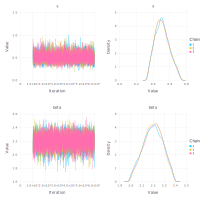

In [36]:
p5 = Mamba.plot(sim1_missing, legend=true)
Mamba.draw(p5[:, 1:2], nrow=2, ncol=2)

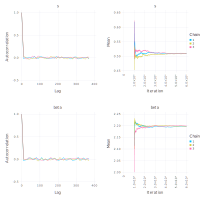

In [37]:
p6 = Mamba.plot(sim1_missing, [:autocor, :mean], legend=true)
Mamba.draw(p6[:, 1:2], nrow=2, ncol=2)

### 次に、空間相関のあるモデル

In [38]:
data2_missing = Dict{Symbol, Any}(
    :y => y_missing,
    :N => length(df.y[:]),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => [0.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0…
  :y   => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN,…
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [39]:
inits2_missing = [
    Dict{Symbol, Any}(
        :y => y_missing,
        :alpha => 0.9,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), data2_missing[:N]),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha => 0.9,:beta => 0.0,:y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s => 1.0,:r => [-0.08394683034105034, -0.04726573163320251, -0.10206864819003565, 0.07213137834238874, -0.15782852781652382, 0.16920155109532464, -0.12368361267547477, -0.06094190615478595, 0.040125046735984195, 0.06686375870152589  …  -0.07512480182908644, -0.011562847672418327, -0.041303664648824324, 0.08144605617350201, 0.05611212296332768, -0.09875527422115522, 0.02901285410626145, -0.01847521850799918, -0.18448437219898056, 0.018522209008822347])
 Dict(:alpha => 0.9,:beta => 0.0,:y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s => 1.0,:r => [0.05183634951108415, -0.07977806500178192, 0.09715106606440166, -0.010427560064728277, 0.016092419974358285, -0.02980706853622067, -0.13461893192383942

In [40]:
scheme2_missing = [
    MISS(:y),
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Dict{Symbol,Mamba.MISSTune}}"
Sampling Block Nodes:
[:y]

CodeInfo(
1 ─ %1 = π (Mamba.var"#263#264"(Core.Box([:y])), Core.Compiler.Const(Mamba.var"#263#264"(Core.Box([:y])), false))
│   %2 = (%1)(model, block)::Core.Compiler.Const(nothing, false)
└──      return %2
) => Nothing

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:r]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
[:s]

CodeInf

In [41]:
setsamplers!(model2, scheme2_missing)
sim2_missing = mcmc(model2, data2_missing, inits2_missing, 60000,
                    burnin=10000, thin=10, chains=3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 2:	Chain 2:   0% [0:16:14 of 0:16:14 remaining]
      From worker 4:	Chain 3:   0% [0:19:47 of 0:19:47 remaining]
      From worker 3:	Chain 1:   0% [0:09:09 of 0:09:09 remaining]
      From worker 2:	Chain 2:  10% [0:04:00 of 0:04:27 remaining]
      From worker 4:	Chain 3:  10% [0:04:19 of 0:04:48 remaining]
      From worker 3:	Chain 1:  10% [0:04:30 of 0:04:60 remaining]
      From worker 2:	Chain 2:  20% [0:03:48 of 0:04:45 remaining]
      From worker 4:	Chain 3:  20% [0:04:02 of 0:05:03 remaining]
      From worker 3:	Chain 1:  20% [0:04:13 of 0:05:16 remaining]
      From worker 2:	Chain 2:  30% [0:03:25 of 0:04:53 remaining]
      From worker 4:	Chain 3:  30% [0:03:36 of 0:05:09 remaining]
      From worker 3:	Chain 1:  30% [0:03:39 of 0:05:13 remaining]
      From worker 2:	Chain 2:  40% [0:02:51 of 0:04:45 remaining]
      From worker 4:	Chain 3:  40% [0:03:00 of 0:05:00 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.24525723732026725 0.9953860507326598 … 4.887933221408017 4.187222610458416; 0.22490718484009997 0.9990126947564848 … 3.903717743338752 2.8674373391393395; … ; 0.32345313695665284 0.9867363857796756 … 2.1644554585388702 1.2554251496218207; 0.4478992679452174 0.9535378032048795 … 2.719552489476323 5.210918530012184]

[0.29496844938966743 0.9580069033487346 … 3.008047893712486 2.7639157553649434; 0.4078710651554016 0.9519619305330461 … 5.273234170864921 2.7008962297996084; … ; 0.2836949998590632 0.9993459688698119 … 2.714253098962814 1.6109389046831457; 0.20729554650387755 0.997673921076969 … 3.0325178633022 3.0125393757323122]

[0.2903773891500874 0.9864919413194058 … 2.3207077620288628 3.411154610140433; 0.24840326713412683 0.9989005558832792 … 2.1836819878747655 2.512001107390751; … ; 0.42435012097205677 0.9740961080701529 … 1.8923072949996358 1.92291019739043; 0.34

In [42]:
describe(sim2_missing)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean        SD        Naive SE       MCSE        ESS   
         s  0.31178878 0.08377669 0.00068403380 0.0015272689 3008.9528
     alpha  0.97162726 0.03434757 0.00028044675 0.0007020716 2393.4772
      beta  2.25097431 0.29077695 0.00237418384 0.0178023060  266.7887
 lambda[1]  2.62260935 1.05045868 0.00857695924 0.0144802109 5000.0000
 lambda[2]  3.18822455 1.03913939 0.00848453756 0.0150432059 4771.6306
 lambda[3]  3.69079375 1.09186972 0.00891507893 0.0160735196 4614.4472
 lambda[4]  4.84413340 1.29529762 0.01057606081 0.0164521851 5000.0000
 lambda[5]  6.01176554 1.54498892 0.01261478167 0.0185450175 5000.0000
 lambda[6]  7.43391563 2.26345601 0.01848104097 0.0298752405 5000.0000
 lambda[7]  8.73655676 2.00698865 0.01638699372 0.0206651689 5000.0000
 lambda[8] 11.37210176 2.47747448 0.02022849441 0.0289552188 5000.0000
 lambda[9] 11.75455161 3.407

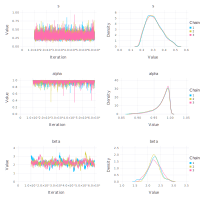

In [43]:
p7 = Mamba.plot(sim2_missing, legend=true)
Mamba.draw(p7[:, 1:3], nrow=3, ncol=2)

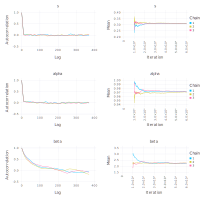

In [44]:
p8 = Mamba.plot(sim2_missing, [:autocor, :mean], legend=true)
Mamba.draw(p8[:, 1:3], nrow=3, ncol=2)

### モデルの比較
空間相関のあるモデル・ないモデルを比較する。

In [45]:
scatter_color = fill(:white, 50)
scatter_color[missing_place] .= :black

9-element view(::Array{Symbol,1}, [6, 9, 12, 13, 26, 27, 28, 29, 30]) with eltype Symbol:
 :black
 :black
 :black
 :black
 :black
 :black
 :black
 :black
 :black

In [46]:
vsspan_x = collect(Iterators.flatten(zip(missing_place .- 0.5, missing_place .+ 0.5)))

18-element Array{Float64,1}:
  5.5
  6.5
  8.5
  9.5
 11.5
 12.5
 12.5
 13.5
 25.5
 26.5
 26.5
 27.5
 27.5
 28.5
 28.5
 29.5
 29.5
 30.5

空間相関を考慮していないモデル

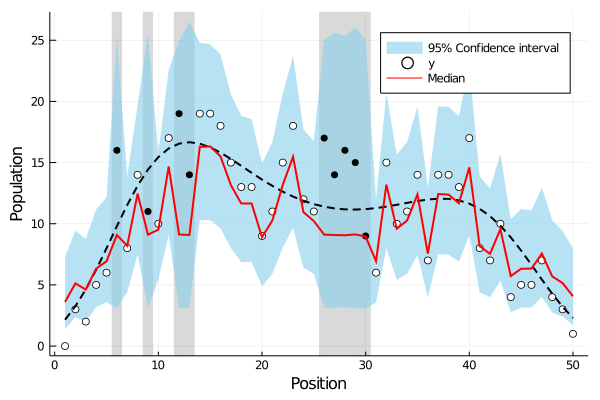

In [47]:
mre3 = quantile(sim1_missing).value[3:end, :]
vspan(vsspan_x, fillcolor=:black, linecolor=:transparent, fillalpha=0.15, label="")
plot!(1:50, mre3[:, 1], lw=0,
    fillrange=mre3[:, 5],
    fillcolor=:skyblue,
    fillalpha=0.6,
    label="95% Confidence interval")
scatter!(1:50, df.y, xlabel="Position", ylabel="Population",
        markercolor=scatter_color, label="y")
plot!(1:50, df.m, linewidth=2, linecolor=:black, linestyle=:dash, label="")
plot!(1:50, mre3[:, 3], linewidth=2, linecolor=:red, label="Median")

空間相関を考慮しているモデル

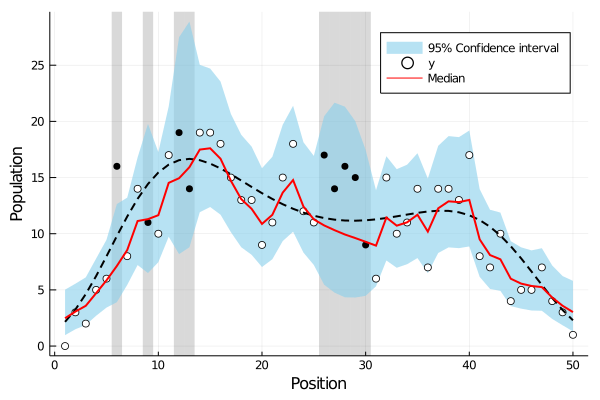

In [48]:
mre4 = quantile(sim2_missing).value[4:end, :]
vspan(vsspan_x, fillcolor=:black, linecolor=:transparent, fillalpha=0.15, label="")
plot!(1:50, mre4[:, 1], lw=0,
    fillrange=mre4[:, 5],
    fillcolor=:skyblue,
    fillalpha=0.6,
    label="95% Confidence interval")
scatter!(1:50, df.y, xlabel="Position", ylabel="Population",
        markercolor=scatter_color, label="y")
plot!(1:50, df.m, linewidth=2, linecolor=:black, linestyle=:dash, label="")
plot!(1:50, mre4[:, 3], linewidth=2, linecolor=:red, label="Median")

空間相関を考慮すると、欠測データに対し隣同士の相互作用を用いた予測ができるため、相関を考慮しないものに比べて予測区間の幅が小さくなる

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*